# PsychRNN — Noise comparison: Baseline vs Noisy RNN (starter)
This notebook trains two versions of a recurrent neural network on the **PerceptualDiscrimination** task using PsychRNN:
- **Baseline RNN**: `rec_noise = 0.0` (no recurrent noise)
- **Noisy RNN**: `rec_noise = 0.1` (adds biological-like recurrent noise)

The notebook contains:
1. Setup & imports
2. Model builder helper (create a Basic RNN with a given rec_noise)
3. Train both models (small demo number of training iterations). You can increase `training_iters` for full experiments.
4. Compare training losses
5. Run psychometric sweeps for both models and plot psychometric curves
6. Visualize hidden-state dynamics (PCA) for one representative test trial from each model

**Important:** This file only *creates* the experiments. Run the notebook in an environment with PsychRNN + compatible TensorFlow installed (see PsychRNN docs). Training cells use small iteration counts so they can run quickly during demos — increase for real results.

In [1]:
!pip install git+https://github.com/murraylab/PsychRNN


  Cloning https://github.com/murraylab/PsychRNN to /tmp/pip-req-build-_o9p60y6
  Running command git clone --filter=blob:none --quiet https://github.com/murraylab/PsychRNN /tmp/pip-req-build-_o9p60y6
  Resolved https://github.com/murraylab/PsychRNN to commit aff98e119d6f0ac780196ec50cc7166509d3938f
  Preparing metadata (setup.py) ... done
  Created wheel for PsychRNN: filename=PsychRNN-1.0.0-py3-none-any.whl size=40503 sha256=d02c453d17fd06b59eb0caef99e242787e84c46f36fca33d5b97e7c4cd308ec4
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvkxd8b7/wheels/2a/c9/d6/9be2347b50d320fe222d5482ab4eb42fbe6742cc5e9ab52f9e
Successfully built PsychRNN


In [1]:
# (Optional) Install PsychRNN in this environment if needed.
# Prefer setting up a conda env as recommended by PsychRNN docs.
# Uncomment to install in-notebook (may conflict with existing TF versions).
# !pip install psychrnn==1.0.0

# Standard imports
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

# reproducibility
seed = 2020
random.seed(seed)
np.random.seed(seed)

import tensorflow as tf
try:
    tf.compat.v2.random.set_seed(seed)
except Exception:
    pass

print('Setup done. If psychrnn is installed, the next cell will import it.')

Setup done. If psychrnn is installed, the next cell will import it.


In [2]:
# PsychRNN imports (adjust if package layout differs)
from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnn.backend.models.basic import Basic
print('Attempting PsychRNN imports... (if this errors, install psychrnn)')

Attempting PsychRNN imports... (if this errors, install psychrnn)


In [3]:
# Helper: build model with custom rec_noise and name
def build_model(rec_noise=0.0, N_rec=50, dt=10, tau=100, T=2000, N_batch=50, name='model'):
    # Create a task object to get default params out of it (task-specific)
    task = PerceptualDiscrimination(dt=dt, tau=tau, T=T, N_batch=N_batch)
    network_params = task.get_task_params()
    network_params['name'] = name
    network_params['N_rec'] = N_rec
    network_params['rec_noise'] = rec_noise
    model = Basic(network_params)
    return task, model

print('Helper ready.')

Helper ready.


In [4]:
# Train both models (demo settings - small iterations)
# Adjust training_iters for better performance in real experiments
dt = 10
tau = 100
T = 2000
N_batch = 64
N_rec = 80

# Baseline (no recurrent noise)
task_baseline, model_baseline = build_model(rec_noise=0.0, N_rec=N_rec, dt=dt, tau=tau, T=T, N_batch=N_batch, name='baseline')

# Noisy RNN (biological-like noise)
task_noisy, model_noisy = build_model(rec_noise=0.1, N_rec=N_rec, dt=dt, tau=tau, T=T, N_batch=N_batch, name='noisy')

# Training parameters (small for demo)
train_params = {}
train_params['save_weights_path'] = None
train_params['training_iters'] = 5000   # demo; increase for final experiments
train_params['learning_rate'] = 1e-3
train_params['loss_epoch'] = 10
train_params['verbosity'] = True
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True

print('Training baseline model...')
losses_baseline, _, _ = model_baseline.train(task_baseline, train_params)
print('Training noisy model...')
losses_noisy, _, _ = model_noisy.train(task_noisy, train_params)

# Save losses to compare later
np.save('losses_baseline.npy', np.array(losses_baseline))
np.save('losses_noisy.npy', np.array(losses_noisy))

print('Training finished (demo). Loss arrays saved: losses_baseline.npy, losses_noisy.npy')

Training baseline model...
Iter 640, Minibatch Loss= 0.171398
Iter 1280, Minibatch Loss= 0.097879
Iter 1920, Minibatch Loss= 0.075784
Iter 2560, Minibatch Loss= 0.062056
Iter 3200, Minibatch Loss= 0.040617
Iter 3840, Minibatch Loss= 0.018782
Iter 4480, Minibatch Loss= 0.020327
Optimization finished!
Training noisy model...
Iter 640, Minibatch Loss= 0.111847
Iter 1280, Minibatch Loss= 0.095699
Iter 1920, Minibatch Loss= 0.084483
Iter 2560, Minibatch Loss= 0.074662
Iter 3200, Minibatch Loss= 0.061521
Iter 3840, Minibatch Loss= 0.040690
Iter 4480, Minibatch Loss= 0.043045
Optimization finished!
Training finished (demo). Loss arrays saved: losses_baseline.npy, losses_noisy.npy


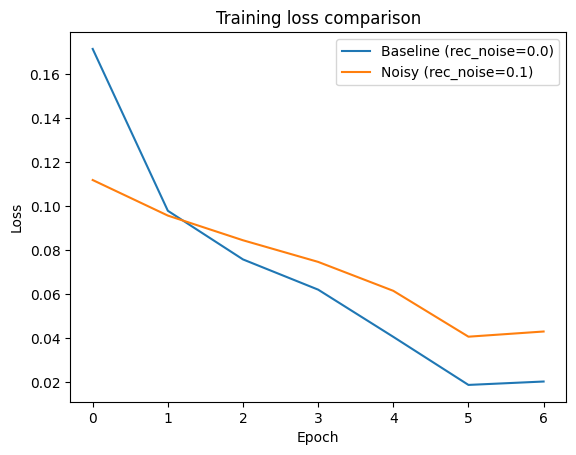

In [5]:
# Plot loss curves for both models
import numpy as np, matplotlib.pyplot as plt
losses_baseline = np.load('losses_baseline.npy', allow_pickle=True)
losses_noisy = np.load('losses_noisy.npy', allow_pickle=True)

plt.figure()
plt.plot(losses_baseline, label='Baseline (rec_noise=0.0)')
plt.plot(losses_noisy, label='Noisy (rec_noise=0.1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss comparison')
plt.legend()
plt.show()

In [6]:
# Psychometric sweep for both models (test only)
import numpy as np
coherences = np.linspace(0.0, 1.0, 9)
n_trials_per_coh = 64

def psychometric_for_model(task_cls, model, coherences, n_trials_per_coh):
    props = []
    for coh in coherences:
        task_test = PerceptualDiscrimination(dt=task_cls.dt, tau=task_cls.tau, T=task_cls.T, N_batch=n_trials_per_coh, coherence=coh)
        x_test, y_test, m_test, _ = task_test.get_trial_batch()
        out, _ = model.test(x_test)
        final_out = out[:, -1, :]
        pred = np.argmax(final_out, axis=1)
        target = np.argmax(y_test[:, -1, :], axis=1)
        props.append(np.mean(pred == target))
    return np.array(props)

print('Running psychometric sweep (this may take some time)...')
props_baseline = psychometric_for_model(task_baseline, model_baseline, coherences, n_trials_per_coh)
props_noisy = psychometric_for_model(task_noisy, model_noisy, coherences, n_trials_per_coh)

# Save
np.save('psych_baseline.npy', props_baseline)
np.save('psych_noisy.npy', props_noisy)
print('Psychometric results saved.')

Running psychometric sweep (this may take some time)...
Psychometric results saved.


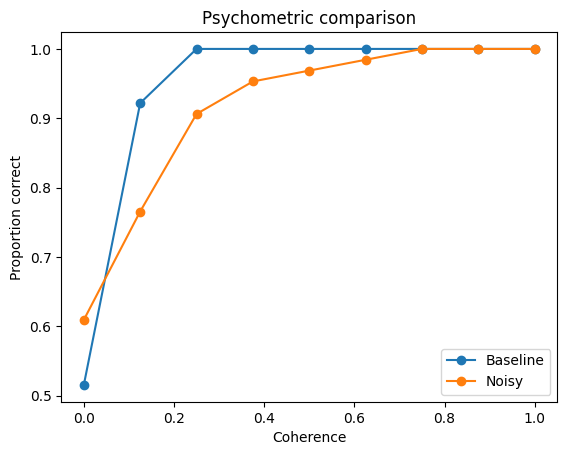

In [7]:
# Load and plot psychometric curves
import numpy as np, matplotlib.pyplot as plt
coherences = np.linspace(0.0, 1.0, 9)
props_baseline = np.load('psych_baseline.npy')
props_noisy = np.load('psych_noisy.npy')

plt.figure()
plt.plot(coherences, props_baseline, marker='o', label='Baseline')
plt.plot(coherences, props_noisy, marker='o', label='Noisy')
plt.xlabel('Coherence')
plt.ylabel('Proportion correct')
plt.title('Psychometric comparison')
plt.legend()
plt.show()

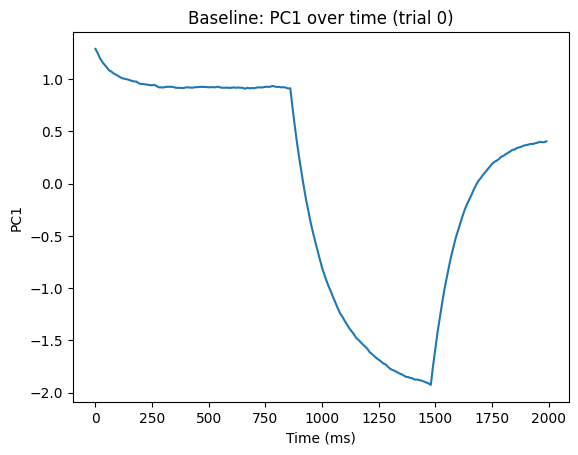

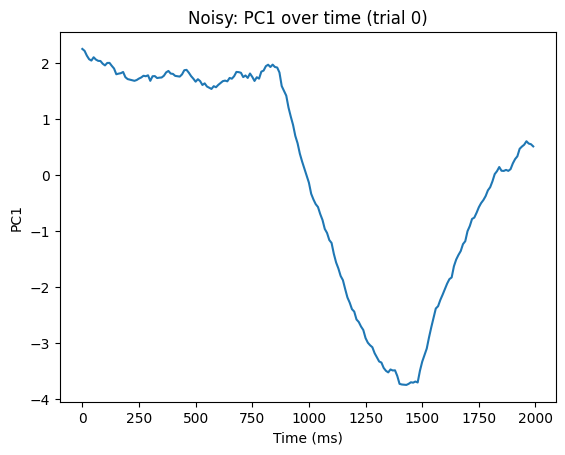

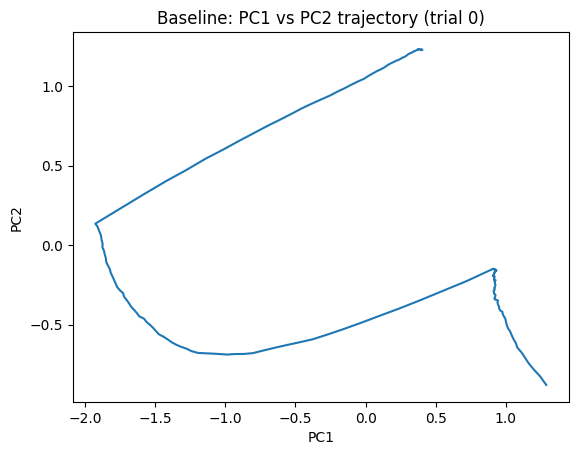

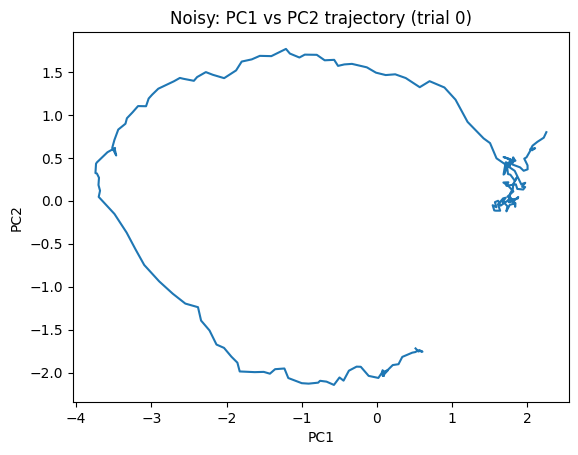

In [8]:
pd_vis = PerceptualDiscrimination(dt=dt, tau=tau, T=T, N_batch=64, coherence=0.6)
x_vis, y_vis, m_vis, _ = pd_vis.get_trial_batch()

_, states_baseline = model_baseline.test(x_vis)
_, states_noisy = model_noisy.test(x_vis)

trial_states_baseline = states_baseline[0,:,:]  # (time, N_rec)
trial_states_noisy = states_noisy[0,:,:]

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pcs_baseline = pca.fit_transform(trial_states_baseline)
pcs_noisy = pca.fit_transform(trial_states_noisy)

# PC1 over time - Baseline
plt.figure()
plt.plot(np.arange(0, pcs_baseline.shape[0]*dt, dt), pcs_baseline[:,0])
plt.xlabel('Time (ms)')
plt.ylabel('PC1')
plt.title('Baseline: PC1 over time (trial 0)')
plt.show()

# PC1 over time - Noisy
plt.figure()
plt.plot(np.arange(0, pcs_noisy.shape[0]*dt, dt), pcs_noisy[:,0])
plt.xlabel('Time (ms)')
plt.ylabel('PC1')
plt.title('Noisy: PC1 over time (trial 0)')
plt.show()

# 2D trajectories
plt.figure()
plt.plot(pcs_baseline[:,0], pcs_baseline[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Baseline: PC1 vs PC2 trajectory (trial 0)')
plt.show()

plt.figure()
plt.plot(pcs_noisy[:,0], pcs_noisy[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Noisy: PC1 vs PC2 trajectory (trial 0)')
plt.show()

In [17]:
# Optionally save model weights
# model_baseline.save('./baseline_weights')
# model_noisy.save('./noisy_weights')
print('Notebook finished. Uncomment save calls to persist weights.')

Notebook finished. Uncomment save calls to persist weights.
